# Compare single step prediction between

* Baseline = tp0
* tp0 using a single initial condition rather than two

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping

from config import SICTester
from prototypes.tp0.config import TP0Tester

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
from functools import partial
import haiku as hk

from graphcast import rollout

from graphufs import construct_wrapped_graphcast
from graphufs.inference import swap_batch_time_dims

In [5]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=None,
) -> xr.Dataset:

    ckpt_id = emulator.num_epochs if ckpt_id is None else ckpt_id
    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    inputs, targets, forcings = dataset.get_xarrays(idx)
    inputs.load()
    targets.load()
    forcings.load()

    # retrieve and drop t0
    inittimes = inputs.datetime.isel(time=-1).values
    inputs = inputs.drop_vars("datetime")
    targets = targets.drop_vars("datetime")
    forcings = forcings.drop_vars("datetime")

    predictions = rollout.chunked_prediction(
        gc,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=np.nan * targets,
        forcings=forcings,
    )

    # Add t0 as new variable, and swap out for logical sample/batch index
    predictions = swap_batch_time_dims(predictions, inittimes)
    targets = swap_batch_time_dims(targets, inittimes)

    return predictions, targets

In [6]:
base = TP0Tester()

In [7]:
sic = SICTester()

In [8]:
bds = Dataset(base, mode="validation")
sds = Dataset(sic, mode="validation")

In [9]:
predictions = {}
targets = {}
for em, ds, label in zip(
    [base, sic],
    [bds, sds],
    ["Baseline", "Single IC"],
):
    predictions[label], targets[label] = predict(
        emulator=em,
        dataset=ds,
    )

### Snapshots

In [10]:
tkw = lambda ax: dict(ha="left", va="center", backgroundcolor="white", transform=ax.transAxes)

In [11]:
def make_plot(vlist):
    nrows = 4
    ncols = len(vlist)
    fig, axs = plt.subplots(nrows, len(vlist), figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True, sharey=True)
    
    ilevel = 0
    index = 10
    ilead = -1
    
    for v, ax in zip(vlist, axs[1]):
        plotme = targets["Baseline"][v].isel(lead_time=ilead).squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
        if v in base.output_transforms:
            plotme = base.output_transforms[v](plotme)
        plotme.plot(ax=ax, cbar_kwargs={"label": ""})
        ax.set(
            xlabel="",
            ylabel="Target" if ax.get_subplotspec().is_first_col() else "",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
    
    plotlist = {k : list() for k in vlist}
    for (key, pred), axr in zip(predictions.items(), [axs[0], axs[2]]):
        
        for v, ax in zip(vlist, axr):
            plotme = pred[v].isel(lead_time=ilead).squeeze()
            target = targets[key][v].isel(lead_time=ilead).squeeze()
            if "level" in plotme.dims:
                plotme = plotme.isel(level=ilevel, drop=True)
                target = target.isel(level=ilevel, drop=True)
                
            if v in base.output_transforms:
                plotme = base.output_transforms[v](plotme)
                target = base.output_transforms[v](target)
    
            plotlist[v].append(plotme)
            mae = np.abs(plotme - target).mean().values
            plotme.plot(ax=ax, cbar_kwargs={"label": ""})
            ax.set(
                xlabel="",
                ylabel=key if ax.get_subplotspec().is_first_col() else "",
                title=v if ax.get_subplotspec().is_first_row() else "",
            )
            ax.text(.15, .1, f"MAE = {mae:1.1e}", **tkw(ax))
            if "spfh" in v:
                ngz = (plotme<0).sum().values
                tot = int(len(plotme.lat) * len(plotme.lon))
                ax.text(.15, .9, f"{ngz} / {tot} < 0", **tkw(ax))
    for v, ax in zip(vlist, axs[-1]):
        diff = plotlist[v][1] - plotlist[v][0]
        diff.plot(ax=ax)
        ax.set(
            xlabel="",
            ylabel="SIC - Baseline" if ax.get_subplotspec().is_first_col() else "",
            title="",
        )
    return fig, axs 

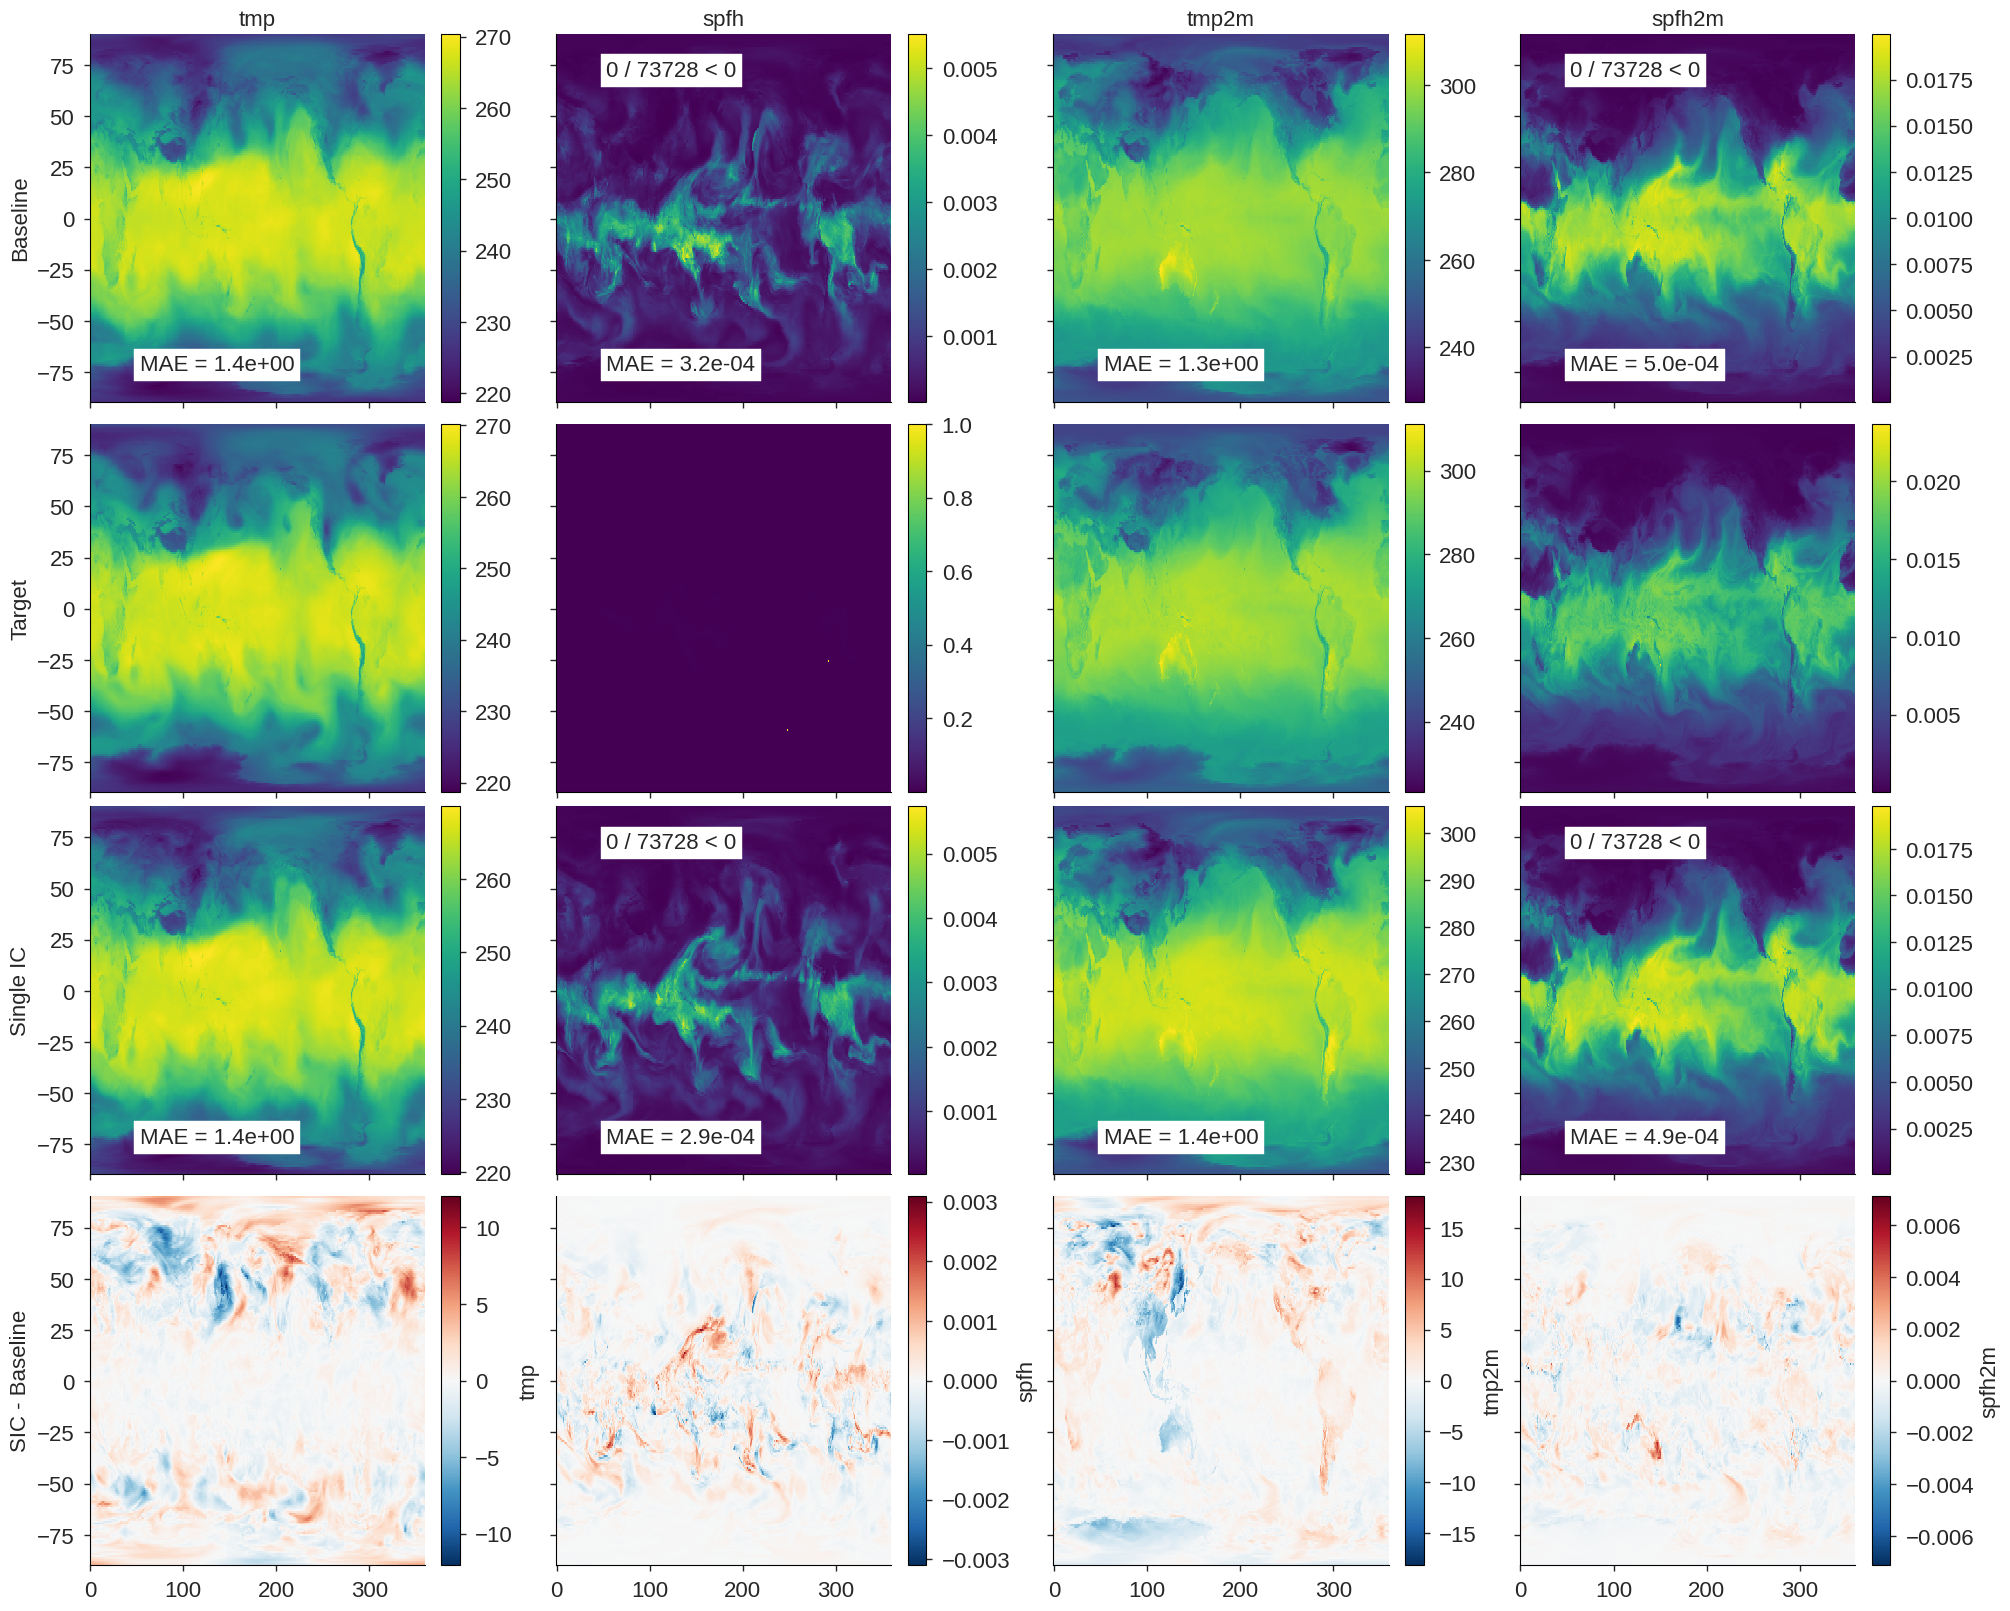

In [12]:
make_plot(["tmp", "spfh", "tmp2m", "spfh2m"]);

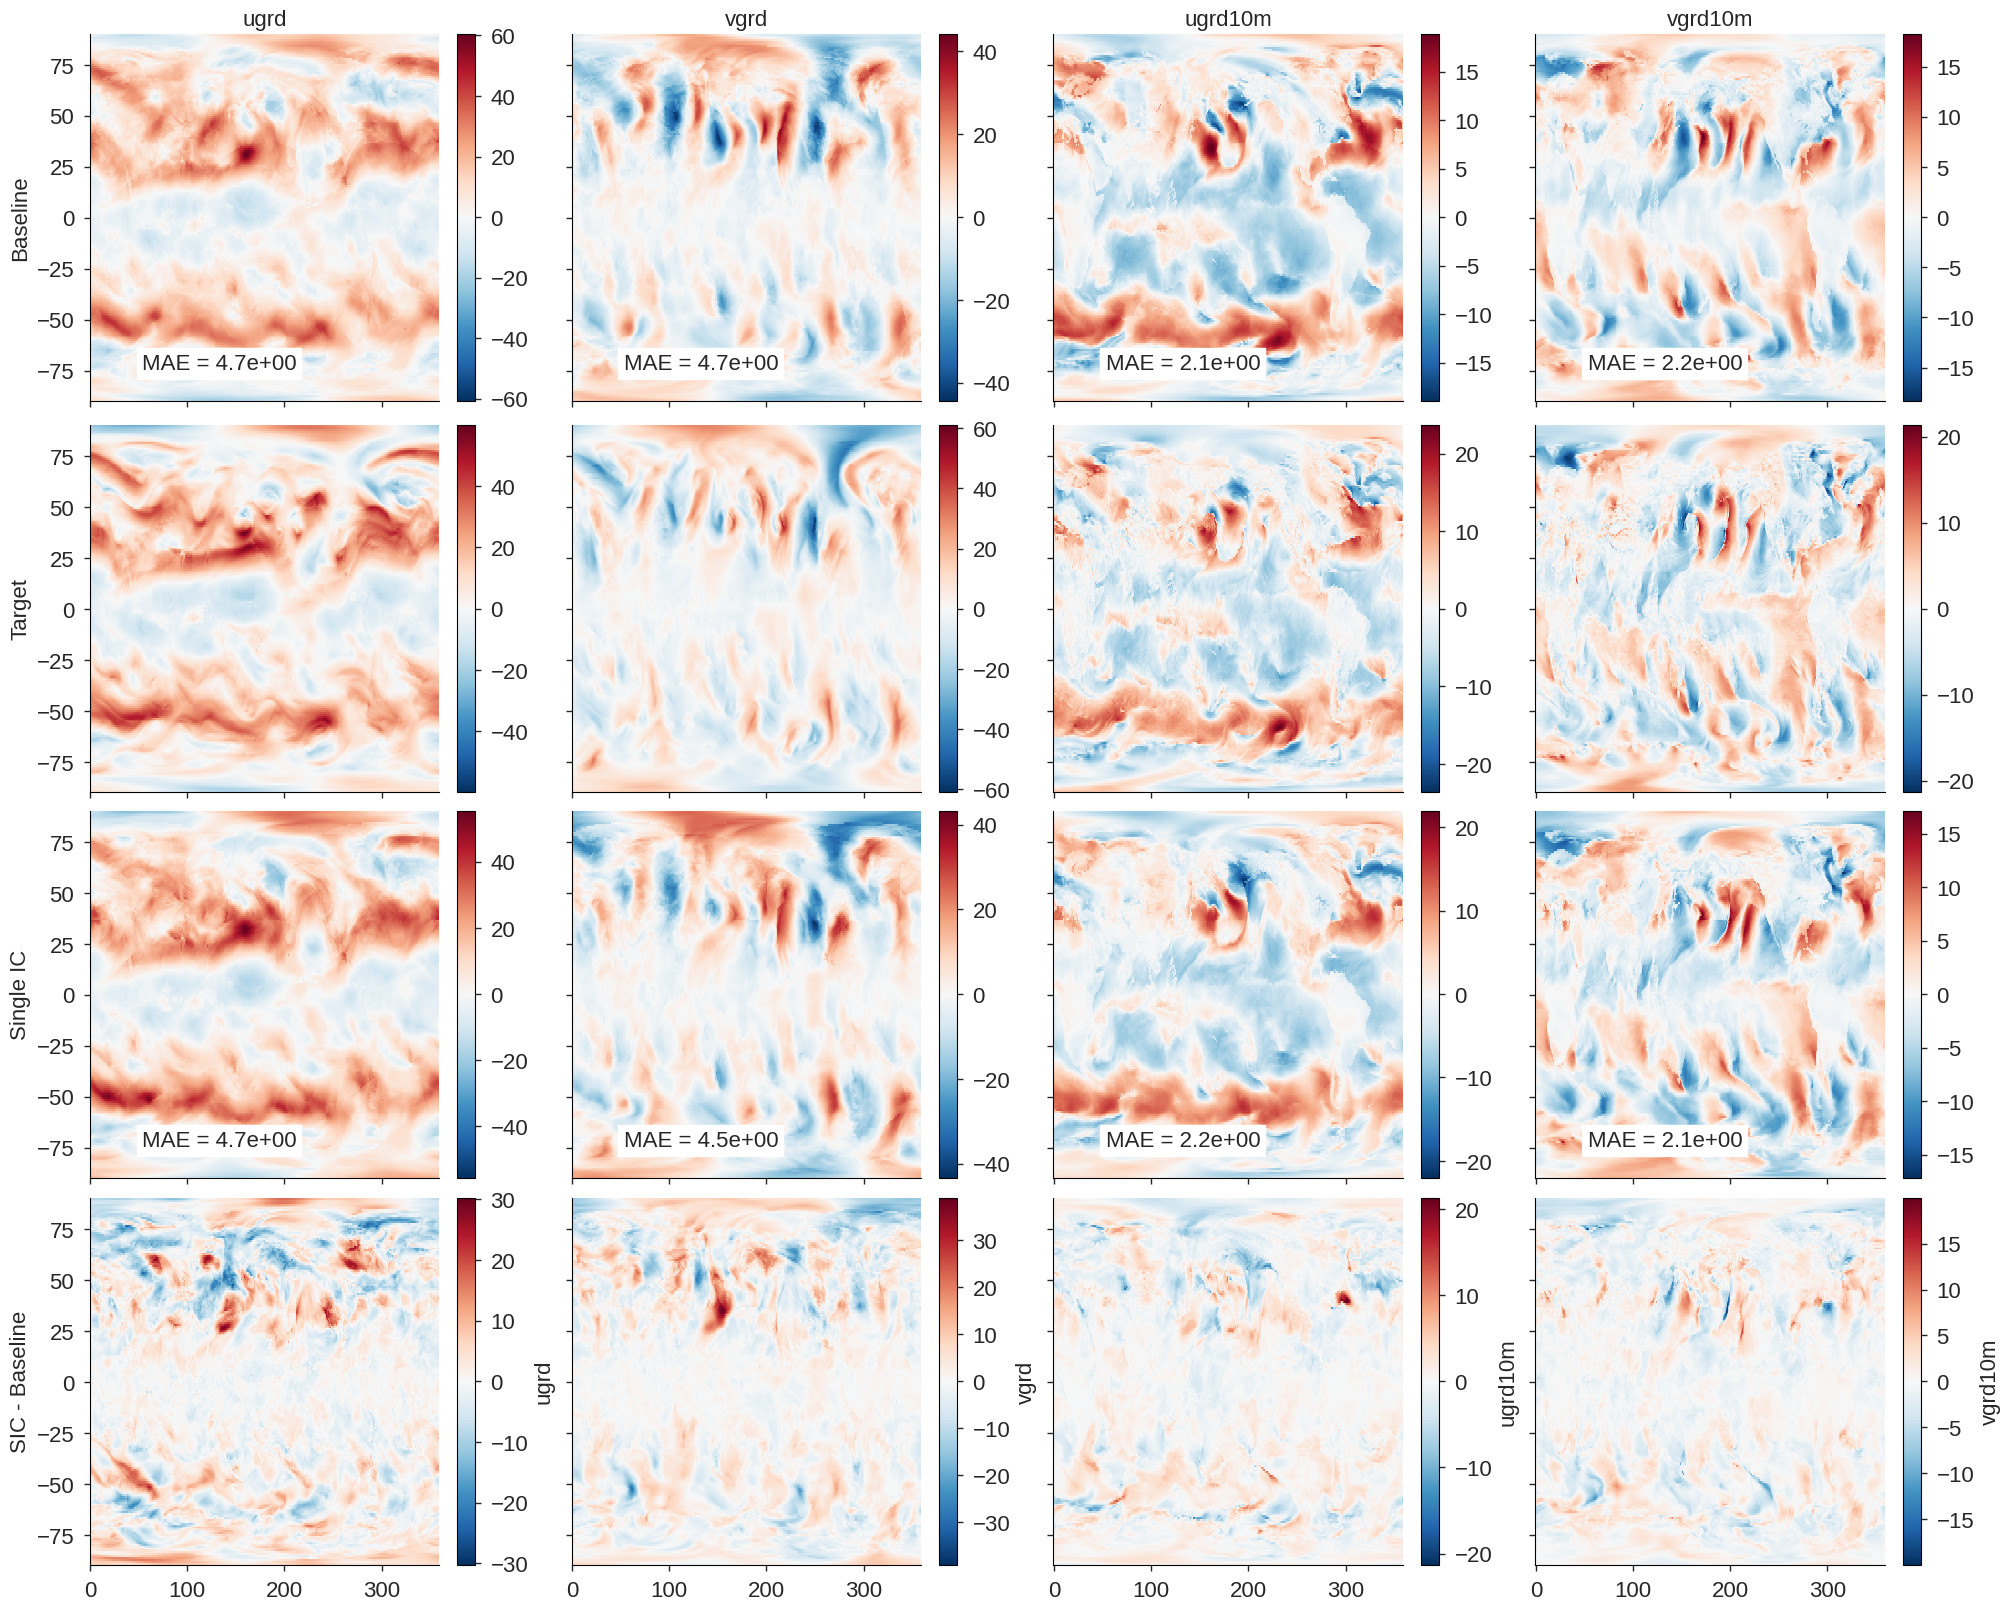

In [13]:
make_plot(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

### Spectra

In [21]:
def plot_spectra(vlist):
    ncols = len(vlist)
    fig, axs = plt.subplots(1, len(vlist), figsize=(ncols*5, 4), constrained_layout=True, sharex=True)
    
    ilevel = 0 
    index = 10
    ilead = -1 
    
    plotlist = {k : list() for k in vlist}
    for cid, (key, pred) in enumerate(predictions.items()):
        
        for v, ax in zip(vlist, axs):
            computer = ZonalEnergySpectrum(v)
            for xds, ls in zip([pred, targets[key].copy()], ["-", ":"]):
                plotme = xds[[v]].squeeze()
                plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
                if "level" in plotme.dims:
                    plotme = plotme.isel(level=ilevel, drop=True)
                plotme = plotme.isel(lead_time=ilead)
                if v in base.output_transforms:
                    plotme = base.output_transforms[v](plotme)
    
                plotme = plotme.compute()
                plotme = computer.compute(plotme)
                plotme = plotme.mean("latitude")
                plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber", linestyle=ls, color=f"C{cid}", label=key)
            ax.set(title=v)
    axs[-1].legend(bbox_to_anchor=(1.1, .5), loc="center left")
    return fig, axs


[(0.003898250787631551, 100.0)]

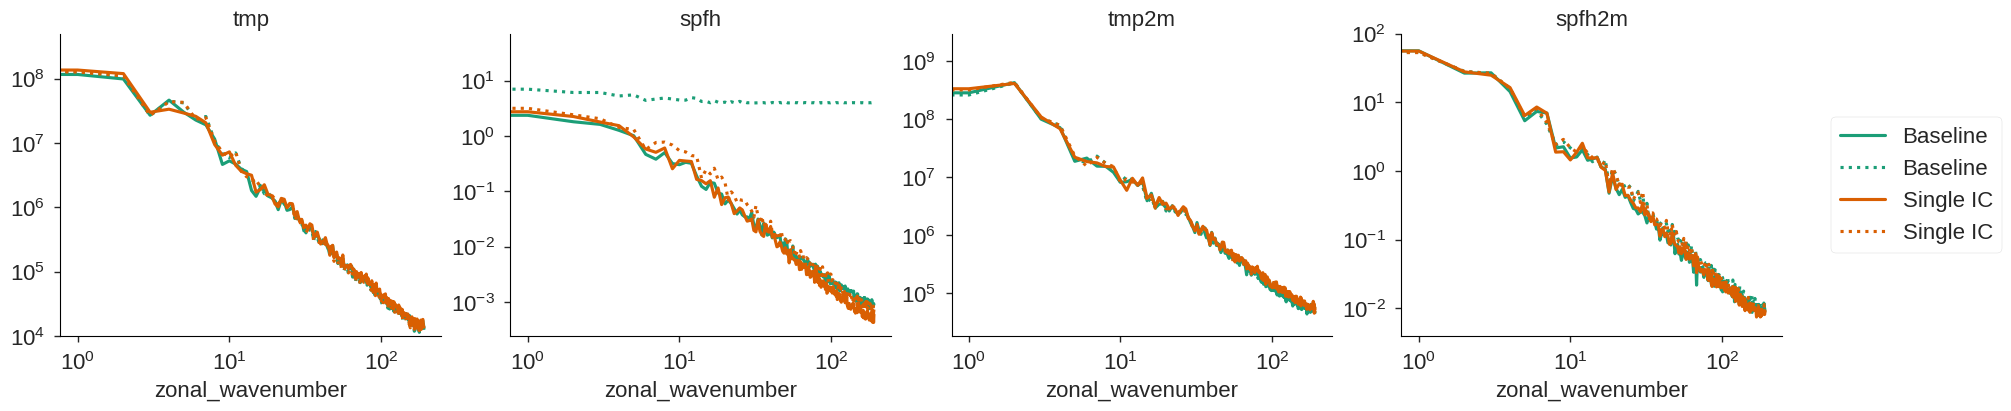

In [22]:
fig, axs = plot_spectra(["tmp", "spfh", "tmp2m", "spfh2m"])
axs[0].set(ylim=(1e4, 5e8))
#axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))


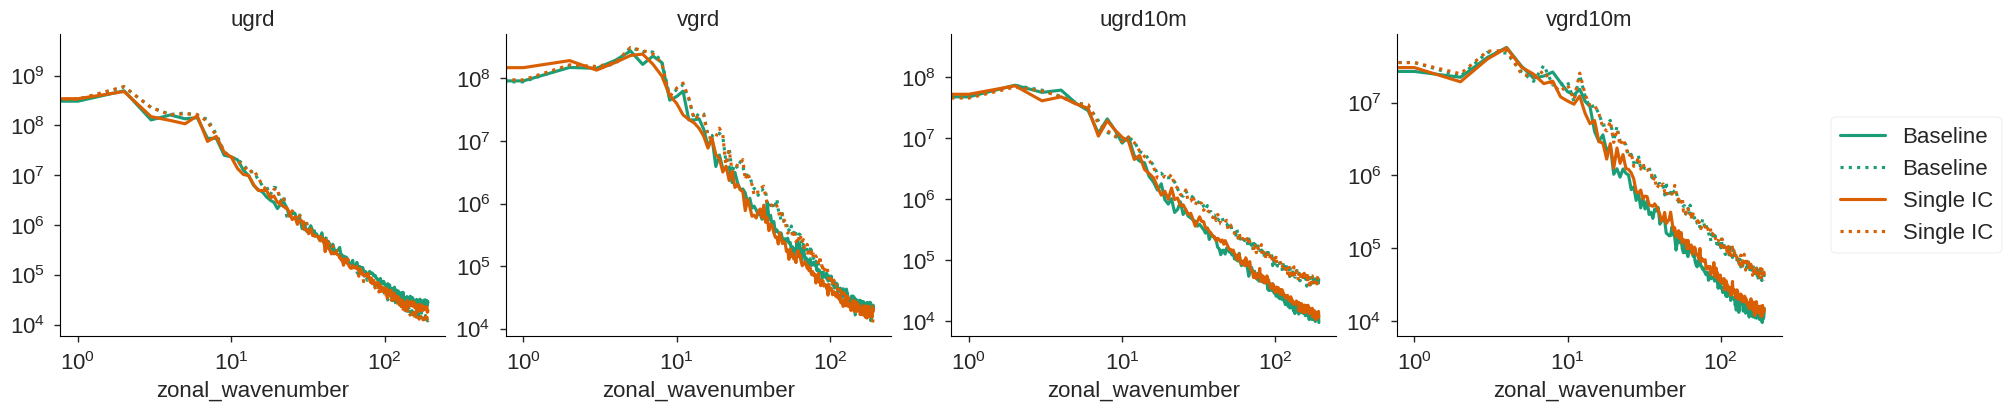

In [23]:
fig, axs = plot_spectra(["ugrd", "vgrd", "ugrd10m", "vgrd10m"])

## Loss


In [24]:
bloss = xr.open_dataset("../tp0/local-output/loss.nc")
sloss = xr.open_dataset("local-output/loss.nc")

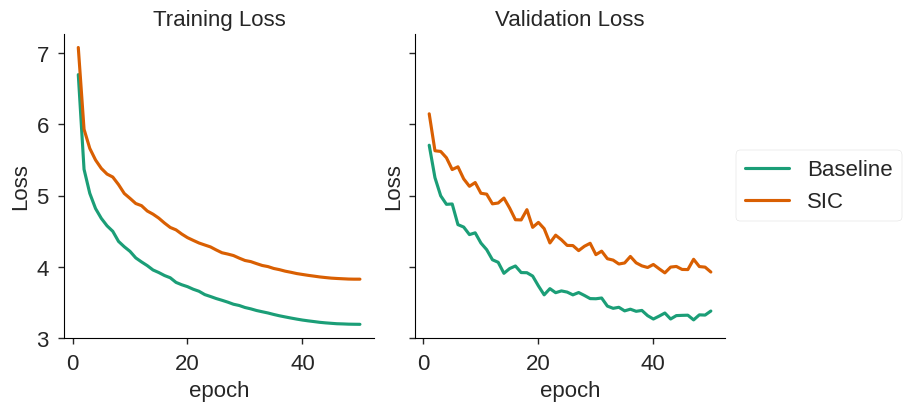

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharey=True)

for key, title, ax in zip(["loss_avg", "loss_valid"], ["Training Loss", "Validation Loss"], axs):
    for xds, label in zip([bloss, sloss], ["Baseline", "SIC"]):
        xds[key].plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
    ax.set(title=title, ylabel="Loss" if ax.get_subplotspec().is_first_row() else "")
    
axs[-1].legend(loc="center left", bbox_to_anchor=(1., .5))

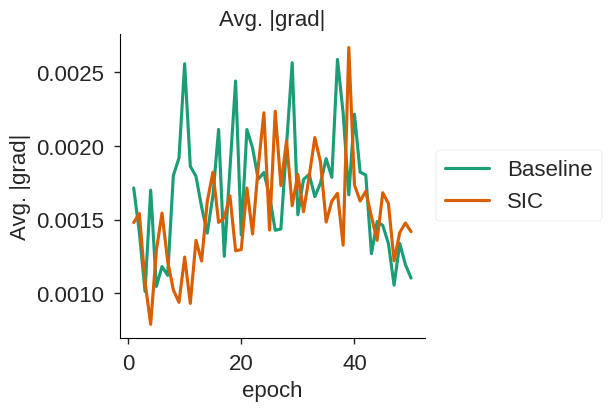

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

key = "mgrad"
title = "Avg. |grad|"

for xds, label in zip([bloss, sloss], ["Baseline", "SIC"]):
    plotme = xds[key]
    plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
ax.set(title=title, ylabel="Avg. |grad|" if ax.get_subplotspec().is_first_row() else "")
    
ax.legend(loc="center left", bbox_to_anchor=(1., .5))